# Multisite phosphorylation
This notebook deals with constructing bond graph models of multisite phosphorylation.

In [1]:
# Import dependencies
import BondGraphTools as bgt
from BondGraphTools.reaction_builder import Reaction_Network
import math
import numpy as np
from matplotlib import pyplot as plt

from general import mpl_settings, save_figure
from plot_options import palette

In [2]:
# Custom plot settings
mpl_settings()

## Four-site phosphorylation
The code below constructs a model of sequential, distributive phosphorylation of a molecule at four sites. The reaction network is below. ATP, ADP and Pi are chemostats in this model.
![](4site_phosphorylation.png)

To streamline the model construction process, the `Reaction_Network` class in BondGraphTools is used. This allows a bond graph to be generated from a series of reactions.

In [3]:
rn = Reaction_Network(name="4-site sequential phosphorylation")
rn.add_reaction("E + S0 + ATP = ES0",name="e1a")
rn.add_reaction("ES0 = E + S1 + ADP",name="e1b")
rn.add_reaction("F + S1 = FS1",name="f1a")
rn.add_reaction("FS1 = F + S0 + Pi",name="f1b")
rn.add_reaction("E + S1 + ATP = ES1",name="e2a")
rn.add_reaction("ES1 = E + S2 + ADP",name="e2b")
rn.add_reaction("F + S2 = FS2",name="f2a")
rn.add_reaction("FS2 = F + S1 + Pi",name="f2b")
rn.add_reaction("E + S2 + ATP = ES2",name="e3a")
rn.add_reaction("ES2 = E + S3 + ADP",name="e3b")
rn.add_reaction("F + S3 = FS3",name="f3a")
rn.add_reaction("FS3 = F + S2 + Pi",name="f3b")
rn.add_reaction("E + S3 + ATP = ES3",name="e4a")
rn.add_reaction("ES3 = E + S4 + ADP",name="e4b")
rn.add_reaction("F + S4 = FS4",name="f4a")
rn.add_reaction("FS4 = F + S3 + Pi",name="f4b")

rn.add_chemostat("ATP")
rn.add_chemostat("ADP")
rn.add_chemostat("Pi")

model = rn.as_network_model(normalised=True)

We choose parameters to provide a good match to the four-site model in Thomson and Gunawardena (doi: 10.1038/nature08102); details are explained in the Appendix of the manuscript.

In [4]:
def set_4site_model_parameters(system):
    # Parameterise chemical potentials of ATP, ADP and Pi to be approximately consistent with
    # physiological free energy of around -50 to -60 kJ/mol
    ATP_potential = 50000/8.314/310 # ΔG_ATP/(RT) (dimensionless)
    ADP_potential = 0.0
    Pi_potential = 0.0
    
    # Assume that the affinities of K_E and K_F are 1
    K_E = 1.0
    K_F = 1.0
    
    args = (ATP_potential,ADP_potential,Pi_potential,K_E,K_F)
    
    # Pick gamma to minimise reverse rate constants of catalysis reactions
    array_gamma = [round_sig(x,3) for x in np.logspace(-8,8,1000)]
    array_J = [reversibility_cost(gamma,*args) for gamma in array_gamma]
    idx_min = np.argmin(array_J)
    gamma = array_gamma[idx_min]
    print(f"gamma = {gamma}")
    
    K_Sn,r_Ea,r_Eb,K_ESn,r_Fa,r_Fb,K_FSn = \
        foursite_energetic_params(gamma,*args)

    # Set parameters for bond graph model
    (system/"SS:ATP").set_param('e',ATP_potential)
    (system/"SS:ADP").set_param('e',ADP_potential)
    (system/"SS:Pi").set_param('e',Pi_potential)
    (system/"C:E").set_param('k',K_E)
    (system/"C:F").set_param('k',K_F)

    for i in range(5):
        (system/f"C:S{i}").set_param('k',K_Sn[i])

    for i in range(4):
        (system/f"C:ES{i}").set_param('k',K_ESn[i])
        (system/f"R:e{i+1}a").set_param('r',r_Ea[i])
        (system/f"R:e{i+1}b").set_param('r',r_Eb[i])
        (system/f"C:FS{i+1}").set_param('k',K_FSn[i])
        (system/f"R:f{i+1}a").set_param('r',r_Fa[i])
        (system/f"R:f{i+1}b").set_param('r',r_Fb[i])
        
def foursite_energetic_params(
    gamma,ATP_potential,ADP_potential,Pi_potential,K_E,K_F):
    
    # Kinetic constants
    aE = [0.00812, 0.102, 0.00812, 0.102] # unit nM/sec
    bE = [0.016, 0.204, 0.016, 0.204] # unit 1/sec
    cE = [0.100, 10.00, 0.100, 10.000] # unit 1/sec
    aF = [0.112, 0.00264, 0.651, 0.00285] # unit nM/sec
    bF = [0.224, 0.005, 1.30, 0.006] # unit 1/sec
    cF = [11.0, 0.017, 63.9, 0.136] # unit 1/sec

    # Calculate affinities of protein substrates. Assume that they follow the equation
    # K_Sn = γ^n
    K_Sn = [gamma**i for i in range(5)]

    # Calculate affinities of the rest of the energetic parameters
    r_Ea = [aE[i]/(K_Sn[i]*K_E*np.exp(ATP_potential)) for i in range(4)]
    K_ESn = [b/ra for b,ra in zip(bE,r_Ea)]
    r_Eb = [c/K_ES for c,K_ES in zip(cE,K_ESn)]
    r_Fa = [aF[i]/(K_Sn[i+1]*K_F) for i in range(4)]
    K_FSn = [b/ra for b,ra in zip(bF,r_Fa)]
    r_Fb = [c/K_FS for c,K_FS in zip(cF,K_FSn)]
    
    return K_Sn,r_Ea,r_Eb,K_ESn,r_Fa,r_Fb,K_FSn

def round_sig(x,sigfig):
    return round(x, sigfig - int(math.floor(math.log10(abs(x))))-1)

def reversibility_cost(
    gamma,ATP_potential,ADP_potential,Pi_potential,K_E,K_F):
    p = foursite_energetic_params(gamma,ATP_potential,ADP_potential,Pi_potential,K_E,K_F)
    K_Sn,r_Ea,r_Eb,K_ESn,r_Fa,r_Fb,K_FSn = p
    
    dE = [r_Eb[i]*K_Sn[i+1]*np.exp(ADP_potential) for i in range(4)]
    dF = [r_Fb[i]*K_Sn[i]*np.exp(Pi_potential) for i in range(4)]
    J = sum(d**2 for d in (dE+dF))
    return J

set_4site_model_parameters(model)

gamma = 34700.0


The species parameters are listed below

In [5]:
Ce_components = [c for c in model.components if c.metamodel=="C"]
for c in Ce_components:
    print(f"{c.name}: {c.params['k']['value']}")

E: 1.0
S0: 1.0
ES0: 524578122.4780043
S1: 34700.0
F: 1.0
FS1: 69400.0
ES1: 18475903762736.55
S2: 1204090000.0
FS2: 2280473484.848485
ES2: 6.316392714945402e+17
S3: 41781923000000.0
FS3: 83435483717357.9
ES3: 2.2246650961673455e+22
S4: 1.4498327281e+18
FS4: 3.052279427578947e+18


The reaction parameters are below

In [6]:
Re_components = [c for c in model.components if c.metamodel=="R"]
for c in Re_components:
    print(f"{c.name}: {c.params['r']['value']}")

e1a: 3.0500700113872715e-11
e1b: 1.9062937571170447e-10
f1a: 3.227665706051873e-06
f1b: 0.0001585014409221902
e2a: 1.1041408453936686e-14
e2b: 5.412455124478768e-13
f2a: 2.1925271366758297e-12
f2b: 7.454592264697822e-12
e3a: 2.5330913896696023e-20
e3b: 1.5831821185435016e-19
f3a: 1.558090085992452e-14
f3b: 7.65861203807059e-13
e4a: 9.169919569082616e-24
e4b: 4.4950586122954e-22
f4a: 1.9657440094726746e-21
f4b: 4.455686421471396e-20


The code below lists the equations of the model

In [7]:
model.constitutive_relations

[dx_0 + 203*x_0*x_1/25000 + 102006614839337*x_0*x_10/1000000000000000 + 651708309083363*x_0*x_13/1000000000000000000 + 102006614839337*x_0*x_3/1000000000000000 + 877170830908339*x_0*x_7/100000000000000000 - 2551*x_12/250 - 29*x_2/250 - 2551*x_6/250 - 29*x_9/250,
 dx_1 + 203*x_0*x_1/25000 + 15850144092219*x_1*x_4/100000000000000000 - 2*x_2/125 - 11*x_5,
 dx_2 - 203*x_0*x_1/25000 - 330741966859807*x_0*x_3/50000000000000000000 + 29*x_2/250,
 dx_3 + 102006614839337*x_0*x_3/1000000000000000 - x_2/10 + 7000016167147*x_3*x_4/62500000000000 - 28*x_5/125 - 51*x_6/250 - 17*x_8/1000,
 dx_4 + 15850144092219*x_1*x_4/100000000000000000 + 65100186167147*x_10*x_4/100000000000000 - 326*x_11/5 + 57*x_13*x_4/20000 - 71*x_14/500 + 7000016167147*x_3*x_4/62500000000000 + 89054145422301*x_4*x_7/25000000000000000 - 1403*x_5/125 - 11*x_8/500,
 dx_5 - 15850144092219*x_1*x_4/100000000000000000 - 14*x_3*x_4/125 + 1403*x_5/125,
 dx_6 - 51*x_0*x_3/500 - 651708309083363*x_0*x_7/1000000000000000000 + 2551*x_6/250,
 d

Below, we simulate the model with different initial conditions. The initial conditions are set to $x_E = x_F = 2.8\ \mu\text{M}$, $x_{S0} = \alpha S_\text{tot}$ and $x_{S3} = (1-\alpha) S_\text{tot}$, where $S_\text{tot} = 10\ \mu\text{M}$ and $\alpha$ is varied between 0 and 0.98.

In [8]:
# Initial concentrations (unit nM)
S_tot = 1e4
E_tot = 2.8e3
F_tot = 2.8e3

# Use some hacks to avoid re-calculating constitutive relations every simulation
class StaticBondGraph(bgt.BondGraph):
    """
    An alternative class for bond graph models that will only re-calculate constitutive relations
    when specified by the user.
    """
    def update_constitutive_relations(self):
        self.stored_constitutive_relations = super().constitutive_relations
    
    @property
    def constitutive_relations(self):
        try:
            result = self.stored_constitutive_relations
        except:
            self.update_constitutive_relations()
            result = self.stored_constitutive_relations
        return result
    
def as_static_network_model(rn, normalised=False):
    system = StaticBondGraph(name=rn.name)
    species_anchor = rn._build_species(system, normalised)
    rn._build_reactions(system, species_anchor, normalised)
    return system

model_sim = as_static_network_model(rn,normalised=True)
set_4site_model_parameters(model_sim)
model_sim.update_constitutive_relations()

species = [comp.name for comp,q in model_sim.state_vars.values()]
idx_E = species.index("E")
idx_F = species.index("F")
idx_S0 = species.index("S0")
idx_S4 = species.index("S4")

alpha_vals = np.arange(0.0,1.0,0.02)
sol_t = []
sol_x = []

for i,alpha in enumerate(alpha_vals):
    x0 = np.zeros(len(model_sim.state_vars))
    x0[idx_E] = E_tot
    x0[idx_F] = F_tot
    x0[idx_S0] = alpha*S_tot
    x0[idx_S4] = (1-alpha)*S_tot

    # Use different time steps for small and large time
    tspan1 = (0.0,1.0)
    tspan2 = (1.0,1000.0)
    t1,x1 = bgt.simulate(model_sim,tspan1,x0,dt=1e-4)
    t2,x2 = bgt.simulate(model_sim,tspan2,x1[-1],dt=1.0)
    t = np.concatenate((t1[:-1],t2))
    x = np.concatenate((x1[:-1],x2))
    sol_t.append(t)
    sol_x.append(x)

gamma = 34700.0


The code below plots the concentrations of S4 over time. There are three possible steady states depending on the initial conditions, and we label them according to colour.

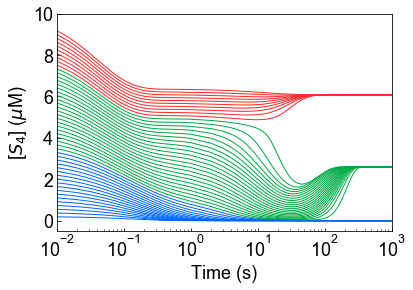

In [9]:
idx_S1 = species.index("S1")
idx_S2 = species.index("S2")
idx_S3 = species.index("S3")

fig = plt.figure()
for alpha,t,x in zip(alpha_vals,sol_t,sol_x):
    x_S4 = x[:,idx_S4]
    if x_S4[-1] < 2000:
        c = palette["blue"]
    elif x_S4[-1] < 5000:
        c = palette["green"]
    else:
        c = palette["red"]
    plt.plot(t,x_S4/1000,color=c,linewidth=1)

plt.xscale('log')
plt.xlim((0.01,1000))
plt.ylim((-0.5,10))
plt.xlabel('Time (s)')
plt.ylabel('[$S_4$] ($\mu$M)')

# Save figure
save_figure(fig,"output/multisite_phosphorylation")

## General models of phosphorylation
The function multisite defined below can be used to create a general model of phosphorylation with $n$ sites and processivity $p$. We use this function to construct and draw a model of phosphorylation with $n=2$ and $p=2$.

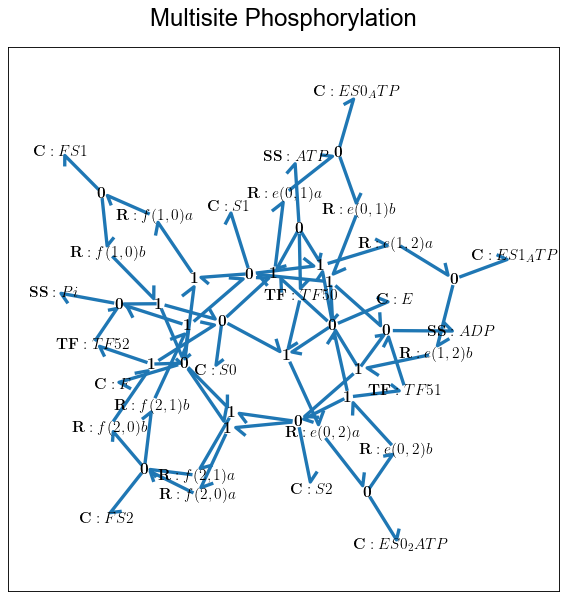

In [10]:
def multisite(n_sites,processivity=1,
              name="Multisite Phosphorylation"):
    substrates = [f"S{i}" for i in range(n_sites+1)]
    (E,F,ATP,ADP,Pi) = ("E","F","ATP","ADP","Pi")

    rn = Reaction_Network(name=name)
    for p in range(1,processivity+1):
        for i in range(n_sites+1-p):
            Sa = substrates[i]
            Sb = substrates[i+p]
            if p == 1:
                p_str = ""
            else:
                p_str = f"{p}*"
                
            # Kinase reactions
            rn.add_reaction(
                f"{Sa}+{E}+{p_str}{ATP}="+
                f"{E}{Sa}_{p_str[:-1]}{ATP}",
                name=f"e({i},{i+p})a")
            rn.add_reaction(
                f"{E}{Sa}_{p_str[:-1]}{ATP}="
                +f"{Sb}+{E}+{p_str}{ADP}",
                name=f"e({i},{i+p})b")
            
            # Phosphatase reactions
            rn.add_reaction(
                f"{Sb}+{F}={F}{Sb}",
                name=f"f({i+p},{i})a")
            rn.add_reaction(
                f"{F}{Sb}={Sa}+{F}+{p_str}{Pi}",
                name=f"f({i+p},{i})b")

    rn.add_chemostat(ATP)
    rn.add_chemostat(ADP)
    rn.add_chemostat(Pi)

    model = rn.as_network_model(normalised=True)
    return model

model = multisite(2,2)
bgt.draw(model)